## This script:
### -Identifies the optimal hyperparameters for an XGBoost model trained on our data
### -Trains this optimized model 
### -Deploys this optimized model 
### -Assesses this model in terms of statistical prowess and operational impact
<br><br>
### Outline of Notebook:

#### 3.1 Establish environment and define variables
#### 3.2 Tune Hyperparameters
#### 3.3 Train Optimized Model
#### 3.4 Deploy Optimized Model
#### 3.5 Make Batch Predictions on Test Data
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u>
#### 3.6 Identify Optimal Likelihood Cutoff for Predictions
#### 3.7 Evaluate Model<br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u>
#### 3.8 Feature Importance
#### 3.9 Assess Financial/Operational Impact of Model

### 2.1 Establish Environment and Define Variables

In [1]:
import sagemaker
from sagemaker.xgboost import XGBoost
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import pandas as pd
import numpy as np
from datetime import datetime

import sagemaker
import boto3
import io
from io import StringIO
from io import BytesIO
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import os
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
smclient = boto3.Session().client('sagemaker')
s3 = boto3.client('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Defining environment variables

In [2]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'diabetes-directory'  # Replace with your S3 bucket name
input_prefix = 'cleaned_diabetes'  # Replace with the S3 prefix where your protobuf data is stored
k_folder = 'k' #folders to facilitate k-fold cross validation

#input_file = 'reduced_dimensions_diabetes_train.csv'
#k_fold_output = 'k_hyp_models' #folders to facilitate k-fold cross validation
test_dataset = 'reduced_dimensions_diabetes_test.csv'
train_dataset = "reduced_dimensions_diabetes_train.csv"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False, header='infer')
    return dataset

In [4]:
s3_train_filepath = 's3://{}/{}/{}'.format(bucket, input_prefix, train_dataset)
s3_test_filepath = 's3://{}/{}/{}'.format(bucket, input_prefix, test_dataset)
hyperparam_output_filepath = "s3://{}/{}/hyperparam_output".format(bucket, input_prefix)
optimized_model_output_filepath = "s3://{}/{}/optimized_output".format(bucket, input_prefix)

Reading dataset

In [5]:
diabetes = CSV_Reader(bucket, input_prefix, train_dataset)

In [6]:
diabetes.sample()

,0,11,13,2,1,5,6,2.1,0.1,0.2,...,0.42,0.43,0.44,0.45,0.46,0.47,0.48,1.4,0.49,0.50
60667,0,58,14,3,0,1,9,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
diabetes.shape

(85095, 62)

Preparing a function which will enable us to send out the 10 distinct train or validation datasets of our 5 K-fold

In [8]:
def Export_Processed_CSV_kfold(bucket, processed_data_folder, k_folder, local_file_name, S3_file_name):
        
    '''Exports a dataframe into CSV format, and sends to a specified S3 bucket location
    
    Arguments 
    --------- 
    bucket: A list of the columns (i.e. the 3 diagnosis columns) to be updated
    processed_data_folder: the relevant subfolder within the main bucket
    local_file_name: The name of the dataframe within the notebook
    S3_file_name: The name of the file uppn export (with .csv extension included)
    header_presence: whether or not a header will be present within the exported csv
    
    Return
    ---------
    Exports a csv file to a specified S3 location'''
    
    local_file_name.to_csv(S3_file_name, index=False, header=False)
    boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}/{}'.format(processed_data_folder, k_folder, S3_file_name)).upload_file(S3_file_name)

In [9]:
# Specifies the number of folds for k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Use globals() to create variables dynamically
for fold, (train_index, valid_index) in enumerate(kf.split(diabetes), 1):
    # Creates variables for train and valid datasets dynamically
    globals()[f'train_data_{fold}'] = diabetes.iloc[train_index].copy()
    globals()[f'validation_data_{fold}'] = diabetes.iloc[valid_index].copy()

Data looks as expected

In [10]:
train_data_1.sample()

,0,11,13,2,1,5,6,2.1,0.1,0.2,...,0.42,0.43,0.44,0.45,0.46,0.47,0.48,1.4,0.49,0.50
18948,0,47,9,3,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Sending each fold compartment to s3

In [11]:
for i in range(1, 6):
    train_dataset_name = f'train_data_{i}'
    train_dataset = globals()[train_dataset_name]
    train_csv_filename = f'{train_dataset_name}.csv'
    Export_Processed_CSV_kfold(bucket, input_prefix, k_folder, train_dataset, train_csv_filename)
    
    validation_dataset_name = f'validation_data_{i}'
    validation_dataset = globals()[validation_dataset_name]
    validation_csv_filename = f'{validation_dataset_name}.csv'
    Export_Processed_CSV_kfold(bucket, input_prefix, k_folder, validation_dataset, validation_csv_filename)

Defining filepaths for each of our 10 respective (5 train 5 validation) dataset folds

In [12]:
train_filepath = []
validation_filepath = []

for i in range(1, 6):
    train_filepath.append(f's3://{bucket}/{input_prefix}/{k_folder}/train_data_{i}.csv')
    validation_filepath.append(f's3://{bucket}/{input_prefix}/{k_folder}/validation_data_{i}.csv')

filepaths_list = list(zip(train_filepath, validation_filepath))
print(filepaths_list)

[('s3://diabetes-directory/cleaned_diabetes/k/train_data_1.csv', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_1.csv'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_2.csv', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_2.csv'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_3.csv', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_3.csv'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_4.csv', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_4.csv'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_5.csv', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_5.csv')]


## 2.2 Tuning Hyperparameters

Specifying Tuning Job parameters

In [13]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        },

      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 2
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    },
    "RandomSeed" : 123
  }

In [17]:
tuning_job_names = []

for i in range(0,5):
    #sagemaker.image_uris.retrieve
    training_image = sagemaker.image_uris.retrieve(framework = 'xgboost', region = 'us-east-1', version = '1.0-1')

    #Identifying the optimal hyperparameters, and specifying input/output file paths
    training_job_definition = {
        "AlgorithmSpecification": {
          "TrainingImage": training_image,
          "TrainingInputMode": "File"
        },
        "InputDataConfig": [
          {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
              "S3DataSource": {
                "S3DataDistributionType": "FullyReplicated",
                "S3DataType": "S3Prefix",
                "S3Uri": filepaths_list[i][0]
              }
            }
          },
          {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
              "S3DataSource": {
                "S3DataDistributionType": "FullyReplicated",
                "S3DataType": "S3Prefix",
                "S3Uri": filepaths_list[i][1]
              }
            }
          }
        ],
        "OutputDataConfig": {
          "S3OutputPath": hyperparam_output_filepath
        },
        "ResourceConfig": {
          "InstanceCount": 1,
          "InstanceType": "ml.c4.2xlarge",
          "VolumeSizeInGB": 10
        },
        "RoleArn": role,
        "StaticHyperParameters": {
          "eval_metric": "auc",
          "num_round": "100",
          "objective": "binary:logistic",
          "rate_drop": "0.3",
          "tweedie_variance_power": "1.4"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 43200
        }
    }
    
    #Tuning and training 
    tuning_job_name = f'd-xgb-{i+1}'
    tuning_job_names.append(tuning_job_name)

    smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name,
                                               HyperParameterTuningJobConfig=tuning_job_config,
                                               TrainingJobDefinition=training_job_definition)

<b>Important</b> It should be noted that the above cell takes a few minutes to run, as it launches multiple hyperparameter tuning jobs. If running this script in your own environment, please wait for these to finish before continuing to run the remainder of the script.

Compiling all k-fold training jobs and ordering them by AUC to identify best performer across 50 individual jobs

In [18]:
best_job_names = []
best_job_hyperparameters = []
auc_scores = []

for i in range(0, 5):
    tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_names[i])
    best_training_job = tuner.dataframe().sort_values('FinalObjectiveValue', ascending=False).iloc[0]
    best_training_job_name = best_training_job['TrainingJobName']

    response = smclient.describe_training_job(TrainingJobName=best_training_job_name)
    best_hyperparameters = response['HyperParameters']
    
    # Append values to the lists
    best_job_names.append(best_training_job_name)
    best_job_hyperparameters.append(best_hyperparameters)

    # Extract AUC from training job metrics
    training_job_metrics = smclient.describe_training_job(TrainingJobName=best_training_job_name)['FinalMetricDataList']
    for metric in training_job_metrics:
        if metric['MetricName'] == 'validation:auc':
            auc_value = metric['Value']
            break
    
    auc_scores.append(auc_value)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/

In [19]:
best_job_names

['d-xgb-1-015-169cb6a4',
 'd-xgb-2-019-adb21fcb',
 'd-xgb-3-007-46e535df',
 'd-xgb-4-011-c77b0ad5',
 'd-xgb-5-002-2166d83c']

In [20]:
auc_scores

[0.6656699776649475,
 0.6603500247001648,
 0.6664999723434448,
 0.6665800213813782,
 0.6716300249099731]

In [21]:
top_jobs = pd.DataFrame(list(zip(best_job_names, auc_scores)), columns = ['job_name', 'auc_scores']).sort_values(by='auc_scores', ascending = False)

Assessing best individual jobs

In [22]:
top_jobs

,job_name,auc_scores
4,d-xgb-5-002-2166d83c,0.67163
3,d-xgb-4-011-c77b0ad5,0.66658
2,d-xgb-3-007-46e535df,0.66650
0,d-xgb-1-015-169cb6a4,0.66567
1,d-xgb-2-019-adb21fcb,0.66035


In [23]:
top_jobs.iloc[0,0]

'd-xgb-5-002-2166d83c'

d-xgb-5-002-2166d83c

In [24]:
response = smclient.describe_training_job(TrainingJobName=top_jobs.iloc[0,0])
best_hyperparameters = response['HyperParameters']

Identifying the best set of hyperparameters- which we will feed into our optimized model

In [25]:
best_hyperparameters

{'_tuning_objective_metric': 'validation:auc',
 'alpha': '0.5885401105511121',
 'eta': '0.20456493857745606',
 'eval_metric': 'auc',
 'max_depth': '2',
 'min_child_weight': '4.905212052590947',
 'num_round': '100',
 'objective': 'binary:logistic',
 'rate_drop': '0.3',
 'tweedie_variance_power': '1.4'}

### 2.3 Train Optimized Model

#### In the below cell, we now train a model with the hyperparameters specified in the above training job(s).

In [26]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", 'us-east-1', "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          #The optimal hyperparameters from tuning are brought into our new model
                                          hyperparameters=best_hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=optimized_model_output_filepath)

# define the data type and paths to the training and validation datasets
content_type = "csv"
train_input = TrainingInput(s3_train_filepath, content_type=content_type)
#validation_input = TrainingInput(s3_test_filepath, content_type=content_type)

# execute the XGBoost training job
estimator.fit({'train': train_input})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-12-03-19-53-08-427


2023-12-03 19:53:08 Starting - Starting the training job...
2023-12-03 19:53:23 Starting - Preparing the instances for training......
2023-12-03 19:54:28 Downloading - Downloading input data...
2023-12-03 19:54:48 Training - Downloading the training image......
2023-12-03 19:55:44 Training - Training image download completed. Training in progress.[2023-12-03 19:56:00.982 ip-10-0-184-166.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-12-03 19:56:01.003 ip-10-0-184-166.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-12-03:19:56:01:INFO] Imported framework sagemaker_xgboost_container.training
[2023-12-03:19:56:01:INFO] Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
[2023-12-03:19:56:01:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2023-12-03:19:56:01:INFO] Failed to parse hyperparameter objective value binary:l

.673 AUC

### 2.4 Deploy Optimized Model

#### Below we deploy our model for inference. The type and instance count of underlying cumpute resources are specified.

In [27]:
deployed_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-12-03-19-56-51-054
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-12-03-19-56-51-054
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-12-03-19-56-51-054


------!

### 2.5 Make Batch Predictions on Test Data

#### Here we read in our holdout test dataset for assessment on the deployed model.

In [28]:
diabetes_test = CSV_Reader(bucket, input_prefix, test_dataset)

In [29]:
diabetes_test.columns

Index(['readmitted', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_inpatient', 'num_procedures',
       'number_diagnoses', 'number_outpatient', 'number_emergency',
       'gender_Male', 'admission_source_id_1', 'change', 'diag_3_Nothing',
       'age_9', 'diag_2_Nothing', 'medication_insulin', 'admission_type_id_3',
       'diag_2_respiratory', 'age_6', 'diag_2_urogenital',
       'medication_glyburide', 'diag_3_metabolic', 'diag_3_respiratory',
       'medication_metformin', 'discharge_disposition_hhealth',
       'diag_1_respiratory', 'diag_1_digestive', 'age_5', 'diag_1_injury',
       'discharge_disposition_outpatient', 'diag_3_urogenital',
       'diag_3_injury', 'diag_1_Nothing', 'discharge_disposition_nursing',
       'any_medication', 'diag_1_urogenital', 'A1Cresult_Norm',
       'diag_3_digestive', 'diag_2_skin', 'discharge_disposition_unknown',
       'A1Cresult_>7', 'admission_source_id_8', 'diag_3_other',
       'discharge_disposition_hospital

#### We seperate our dependent and independent variables from the test dataset, so that they can be fed to the deployed model for a patch prediction job.

In [31]:
test_X = diabetes_test.drop(columns='readmitted').values
test_y = diabetes_test['readmitted'].values

#### Here we make the necessary specifications to format our data, and then feed it to the deployed model.
<br>
Our responses are returned to us in a list of values (between 0 and 1) demonstrating how likely each individual record is to be readmitted.

In [32]:
deployed_predictor.serializer = sagemaker.serializers.CSVSerializer()
deployed_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [33]:
predictions = []
results = deployed_predictor.predict(test_X)
predictions += [r['score'] for r in results['predictions']]

print(len(predictions))

15018


In [34]:
diabetes_test['predictions'] = predictions

In [35]:
diabetes_test.shape

(15018, 63)

In [36]:
%matplotlib inline

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#### Here we will look at the distribution of our prediction values.

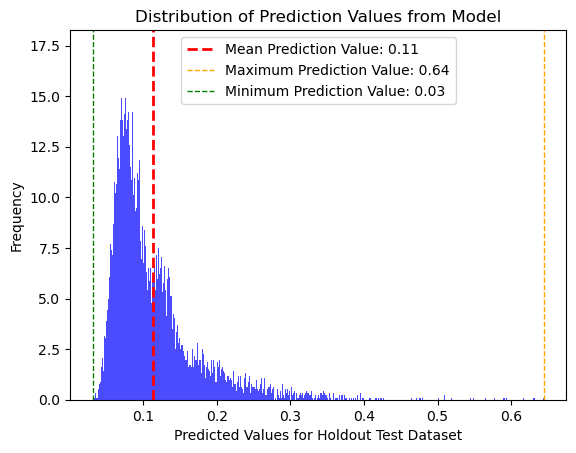

The mean predictive value for the test dataset is: 0.11326750564909971


In [37]:
plt.hist(diabetes_test.predictions, bins=1000, density=True, alpha=0.7, color='blue')
plt.xlabel('Predicted Values for Holdout Test Dataset')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Values from Model')

mean_value = np.mean(diabetes_test.predictions)
max_value = np.max(diabetes_test.predictions)
min_value = np.min(diabetes_test.predictions)


# Add mean line to the histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

plt.axvline(max_value, color='orange', linestyle='dashed', linewidth=1, label=f'Maximum Prediction Value: {max_value:.2f}')

plt.axvline(min_value, color='green', linestyle='dashed', linewidth=1, label=f'Minimum Prediction Value: {min_value:.2f}')


# Display legend
plt.legend()

# Show the histogram
plt.show()

print('The mean predictive value for the test dataset is: {}'.format(mean_value))

### 2.6. Identify Optimal Likelihood Cutoff for our Predictions

As we can see here, our algorithm is hesitant to place much predictive weight behind any particular patient record, and so the majority of our predictions are centered near 0.1 and skew right. As the dataset is weighted heavily towards those who were not readmitted (i.e about 1 in 10 patients being readmitted), this makes sense.

We will therefore institute a prediction/rounding cutoff value lower than 0.5 to determine which records are predicted as being readmitted. As the mean prediction is around 0.11, using this value instead of 0.5 would likely predict around half of records as being classified as readmissions.

We will therefore use a average of these predictions is likely a good place to start. Let us try this value, as well with a few other values to see which cutoff value gives us the best statistical outcome.

As mentioned earlier, optimizing the Area Under the Curve (AUC) metric will be our highest priority, as this metric takes into account both false positives and false negatives.

#### Here we create new lists that will cut probabilities, starting near the mean (11%) and the refining to more precise values.

In [38]:
def XGB_Statistical_Evaluation(probability_rounding_threshold_values, names_of_levels):
    
    '''The CSV_Reader() function takes different readmission predictions, based off of different likelihood roundoff 
    values, and computes different 
    
    Arguments 
    --------- 
    probability_rounding_threshold_values: A list of probabilities for each likelihood cutoff value
    subfolder: A list of names for each item of the probability_rounding_threshold_values list, representing 
        the implimented likelihood cutoff value
    
    Return
    ---------
    For each prediction list, the following is computed:
    -The likelihood cutoff value being used
    -The number of predicted positived
    -The accuracy of the predictions
    -The precision of the predictions
    -The recall of the predictions
    -The F1 score of the predictions
    -The ROC AUC score of the predictions
    '''
    
    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = diabetes_test['readmitted']
        scores = precision_recall_fscore_support(y_test, i, average='macro', labels=np.unique(i))
        acc = accuracy_score(y_test, i)
        roc = roc_auc_score(y_test, i)
        positives = sum(i)

        
        print()
        print('The cutoff percentage being used for predictions is: {}'.format(j))
        print('Number of predicted readmissions: {}'.format(positives))
        print('Accuracy is: {}'.format(acc))
        print('Precision is: {}'.format(scores[0]))
        print('Recall is: {}'.format(scores[1]))
        print('F1 score is: {}'.format(scores[2]))     
        print('ROC AUC score (i.e. the metric of primary interest) is: {}'.format(roc))

First we will start looking around .01 differences within the prediction cutoff threshold, starting at 0.11 or 11%

In [39]:
thresholds = [0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07]

for threshold in thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in diabetes_test["predictions"]]

threshold_list = [pred_15, pred_14, pred_13, pred_12, pred_11, pred_1, pred_09, pred_08, pred_07]
threshold_list_names = ["pred_15", "pred_14", "pred_13", "pred_12", "pred_11", "pred_1", "pred_09", "pred_08", "pred_07"]

In [41]:
threshold_list = [pred_15, pred_14, pred_13, pred_12, pred_11, pred_1, pred_09, pred_08, pred_07]
threshold_list_names = ["pred_15", "pred_14", "pred_13", "pred_12", "pred_11", "pred_1", "pred_09", "pred_08", "pred_07"]

In [42]:
XGB_Statistical_Evaluation(threshold_list, threshold_list_names)


The cutoff percentage being used for predictions is: pred_15
Number of predicted readmissions: 2672
Accuracy is: 0.7891863097616194
Precision is: 0.5666499598405651
Recall is: 0.5983258405902512
F1 score is: 0.5743004583771802
ROC AUC score (i.e. the metric of primary interest) is: 0.5983258405902512

The cutoff percentage being used for predictions is: pred_14
Number of predicted readmissions: 3205
Accuracy is: 0.7659475296311093
Precision is: 0.5645222951049592
Recall is: 0.6092453836986865
F1 score is: 0.5700635164622243
ROC AUC score (i.e. the metric of primary interest) is: 0.6092453836986865

The cutoff percentage being used for predictions is: pred_13
Number of predicted readmissions: 3926
Accuracy is: 0.7324543880676522
Precision is: 0.5610174819079035
Recall is: 0.6188281912699466
F1 score is: 0.5591565846187897
ROC AUC score (i.e. the metric of primary interest) is: 0.6188281912699466

The cutoff percentage being used for predictions is: pred_12
Number of predicted readmissi

It looks as though .12 gives us the best value. Let us dig deeper by observing AUC changes at the .001 place to see if we can improve our AUC.

In [43]:
mp_thresholds = [0.124, 0.123, 0.122, 0.121, 0.12, 0.119, 0.118, 0.117, 0.116]

for threshold in mp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in diabetes_test["predictions"]]

In [44]:
more_precise_rounding_threshold_predictions = [pred_124, pred_123, pred_122, pred_121, pred_11, pred_119, pred_118, pred_117, pred_116]
more_precise_names_of_levels = ['12.4%', '12.3%','12.2%', '12.1%', '11%', '11.9%', '11.8%', '11.7%', '11.6%']

In [45]:
XGB_Statistical_Evaluation(more_precise_rounding_threshold_predictions, more_precise_names_of_levels)


The cutoff percentage being used for predictions is: 12.4%
Number of predicted readmissions: 4461
Accuracy is: 0.7062857903848715
Precision is: 0.5582219340373986
Recall is: 0.622620878171432
F1 score is: 0.5483382579762726
ROC AUC score (i.e. the metric of primary interest) is: 0.622620878171432

The cutoff percentage being used for predictions is: 12.3%
Number of predicted readmissions: 4553
Accuracy is: 0.7018910640564656
Precision is: 0.5579776605712683
Recall is: 0.6235385841685005
F1 score is: 0.5466055584264705
ROC AUC score (i.e. the metric of primary interest) is: 0.6235385841685004

The cutoff percentage being used for predictions is: 12.2%
Number of predicted readmissions: 4634
Accuracy is: 0.6972965774404049
Precision is: 0.5569342679185734
Recall is: 0.6225178872396426
F1 score is: 0.5439760562780065
ROC AUC score (i.e. the metric of primary interest) is: 0.6225178872396427

The cutoff percentage being used for predictions is: 12.1%
Number of predicted readmissions: 4734


11.9 seems to be optimal. Let us now explore the 0.0001 place.

In [49]:
emp_thresholds = [0.1194, 0.1193, 0.1192, 0.1191, 0.119, 0.1189, 0.1188, 0.1187, 0.1186]

for threshold in emp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in diabetes_test["predictions"]]

In [50]:
emp_threshold_list = [pred_1194, pred_1193, pred_1192, pred_1191, pred_119, pred_1189, pred_1188, pred_1187, pred_1186]
emp_threshold_variable_names = ["pred_1194", "pred_1193", "pred_1192", "pred_1191", "pred_119", "pred_1189", "pred_1188", "pred_1187", "pred_1186"]

In [51]:
XGB_Statistical_Evaluation(emp_threshold_list, emp_threshold_variable_names)


The cutoff percentage being used for predictions is: pred_1194
Number of predicted readmissions: 4890
Accuracy is: 0.6849114396058064
Precision is: 0.5562924020391746
Recall is: 0.6246772980617492
F1 score is: 0.538849304515223
ROC AUC score (i.e. the metric of primary interest) is: 0.6246772980617491

The cutoff percentage being used for predictions is: pred_1193
Number of predicted readmissions: 4898
Accuracy is: 0.6845119190304967
Precision is: 0.5562611261836322
Recall is: 0.6247132979315235
F1 score is: 0.5386692258779266
ROC AUC score (i.e. the metric of primary interest) is: 0.6247132979315235

The cutoff percentage being used for predictions is: pred_1192
Number of predicted readmissions: 4907
Accuracy is: 0.6843121587428419
Precision is: 0.5565099516822412
Recall is: 0.6253834321533485
F1 score is: 0.5388313286117615
ROC AUC score (i.e. the metric of primary interest) is: 0.6253834321533485

The cutoff percentage being used for predictions is: pred_1191
Number of predicted re

11.92% Let us see if we can get any better performance at the 0.00001 place.

In [52]:
vp_thresholds = [0.11924, 0.11923, 0.11922, 0.11921, 0.1192, 0.11919, 0.11918, 0.11917, 0.11916]

for threshold in vp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in diabetes_test["predictions"]]

In [53]:
vp_threshold_list = [pred_11924, pred_11923, pred_11922, pred_11921, pred_1192, pred_11919, pred_11918, pred_11917, pred_11916]
vp_threshold_name_list = ["pred_11924", "pred_11923", "pred_11922", "pred_11921", "pred_1192", "pred_11919", "pred_11918", "pred_11917", "pred_11916"]

In [54]:
XGB_Statistical_Evaluation(vp_threshold_list, vp_threshold_name_list)


The cutoff percentage being used for predictions is: pred_11924
Number of predicted readmissions: 4904
Accuracy is: 0.6841123984551871
Precision is: 0.5561242536551502
Recall is: 0.6244884440865228
F1 score is: 0.53838816621537
ROC AUC score (i.e. the metric of primary interest) is: 0.6244884440865228

The cutoff percentage being used for predictions is: pred_11923
Number of predicted readmissions: 4904
Accuracy is: 0.6841123984551871
Precision is: 0.5561242536551502
Recall is: 0.6244884440865228
F1 score is: 0.53838816621537
ROC AUC score (i.e. the metric of primary interest) is: 0.6244884440865228

The cutoff percentage being used for predictions is: pred_11922
Number of predicted readmissions: 4905
Accuracy is: 0.6841789852177387
Precision is: 0.5562528443874736
Recall is: 0.6247867734421313
F1 score is: 0.5385359252884321
ROC AUC score (i.e. the metric of primary interest) is: 0.6247867734421313

The cutoff percentage being used for predictions is: pred_11921
Number of predicted r

It looks as though we have gone through precision-cutoff values, to the point where our AUC will be optimized (cutoff: 11.92%, AUC: 0.6254)

From the above results, we can see that a cutoff value of 11.19% (i.e. those predicted as being at/above 11.19% risk of readmission, are designated as such) gives us the greatest Area-Under-The-Curve value of 0.6254.

This can be roughly interpreted as: "Given a random readmitted/positive record, and random not-readmitted/negative record, the algorithm will correctly identify the positive record as being more likely to be readmitted than the negative record, 63% of the time.

This value of 0.63 is fairly close to the AUC value of 0.67 that we recieved from our best hyperparameter tuning session off of the validation data subset. This indicates that while there is likely some degree of overfitting present, overall our model does a good job at providing generalizable, unbiased predictions across the entire patient population.

Although the accuracy and precission have decreased due to our lower prediction cutoff point, we are able to predict these costly readmissions demonstratably better with the algorithm than without.

#### Defining our optimal prediction values

In [55]:
optimal_cutoff = pred_1192

### 2.7. Evaluate Model

#### This cell creates the function that will be used to produce a confusion matrix for the predictions derived from the Test dataset.

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def Plot_Confusion_Matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    
    '''The Plot_Confusion_Matrix() function produces a confusion matrix with which to view our final results.
    
    Arguments 
    --------- 
    y_true: the actual readmission values for the test dataset
    y_pred: the predicted readmission values for the test dataset
    classes: The names for the outcome possibilities (i.e. readmitted/not readmitted) 
    title: chart title
    cmap: sets the color gradient
    
    Return
    ---------
    Returns the specified confusion matrix '''
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#### The below cell produces the confusion matrix detainkling our predictions

In [57]:
#from io import BytesIO

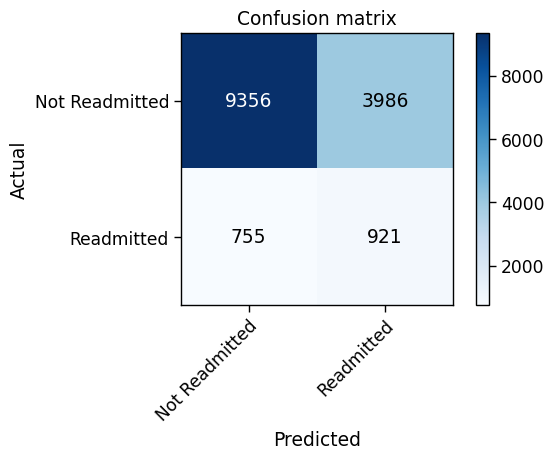

In [58]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = diabetes_test['readmitted']
y_pred = optimal_cutoff

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)


# Save the table as a PNG image in memory
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Upload the image to S3
file_path = 'image_outputs/'
file_name = 'xgb_confusion_matrix.png'  # Specify the desired file name in S3
file_key = file_path + file_name

s3_client = boto3.client('s3')
s3_client.upload_fileobj(buffer, bucket, file_key)


plt.show()

In [59]:
len(diabetes_test)

15018

In [60]:
XGB_Statistical_Evaluation([optimal_cutoff],["11.92%"])


The cutoff percentage being used for predictions is: 11.92%
Number of predicted readmissions: 4907
Accuracy is: 0.6843121587428419
Precision is: 0.5565099516822412
Recall is: 0.6253834321533485
F1 score is: 0.5388313286117615
ROC AUC score (i.e. the metric of primary interest) is: 0.6253834321533485


As can be seen in the above confusion matrix, although we are <u>identifying a little more than one third (39%) of patients as being at risk</u> for a readmission, we were <u>correctly identifying close to two thirds (61%) of all correct cases</u> among this prediction subset.

### 2.9. Assess Financial/Operational Impact of Model

#### To complete our assessment, let us determine the impact our algorithm would have had if implemented on our entire dataset in terms of:<br>
   1. Readmissions Prevented<br>
   2. Dollars Saved

#### Let us identify the relevant numbers from our confusion matrix necessary to populate our financial assessment (i.e. our: 
   True Positives<br>
   False Positives<br>
   False Negatives<br><br>
These correspond to the bottom right, top right, and bottom left cells of the prior confusion matrix.

In [61]:
cm2 = confusion_matrix(diabetes_test['readmitted'], optimal_cutoff)

True_Positives_those_correctly_flagged = cm2[1][1]
False_Positives_those_incorrectly_flagged = cm2[0][1]
False_Negatives_those_missed = cm2[1][0]

print('The number of True Positives (those correctly flagged) is: {}'.format(True_Positives_those_correctly_flagged))
print('The number of False Positives (those incorrectly flagged) is: {}'.format(False_Positives_those_incorrectly_flagged))
print('The number of False Negatives (those missed) is: {}'.format(False_Negatives_those_missed))

The number of True Positives (those correctly flagged) is: 921
The number of False Positives (those incorrectly flagged) is: 3986
The number of False Negatives (those missed) is: 755


#### Next, let us define a few variables: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>cost of each readmission</u> is estimated at <u>$15,000</u> <br><br>
   A diabetes-management-program is a patient-follow-up regimen, with the goal of preventing a readmission, and ultimately enabling the patient to manage their diabetes.<br><br>
   
The following variables pertaining to readmissions are defined/estimated below:<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>cost of implimenting the diabetes-management-program</u> for 1 month is estimated at <u>$500</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>likelihood</u> of the diabetes-management-program <u>preventing a readmission is</u> estimated at <u>50%</u><br><br>

Obviously, each of these variables are likely to vary across health systems, and these are just estimation values. However an update of these variables would enable a simple update of this assessment.

In [62]:
cost_of_readmission = 15000
cost_of_management_program = 500
sucess_rate_of_intervention = 0.5

#### Below we calculate the total cost of the program, and the total number of readmissions that the program would prevent.

In [63]:
total_cost_of_implimenting_program = cost_of_management_program*(True_Positives_those_correctly_flagged+False_Positives_those_incorrectly_flagged)

readmissions_prevented = sucess_rate_of_intervention*True_Positives_those_correctly_flagged

print('The total cost of implementing the program across the {} patients deemed to be "at risk" by the algorithm would be: ${}'.format((True_Positives_those_correctly_flagged + False_Positives_those_incorrectly_flagged), total_cost_of_implimenting_program))
print('The total number of prevented readmissions would be : {}'.format(readmissions_prevented))

The total cost of implementing the program across the 4907 patients deemed to be "at risk" by the algorithm would be: $2453500
The total number of prevented readmissions would be : 460.5


#### Now, we calculate the difference between the expense of implimenting the program (about $2 Million) with the savings from prevented readmissions.

In [64]:
savings_from_readmissions_prevention = (readmissions_prevented) * (cost_of_readmission)

net_savings_to_hosptial_system = (savings_from_readmissions_prevention) - (total_cost_of_implimenting_program)

per_patient_savings = net_savings_to_hosptial_system/len(optimal_cutoff)

print('The savings stemming from prevented readmissions would be: ${}'.format(savings_from_readmissions_prevention))
print('The net savings from implementing the program would be : ${}'.format(net_savings_to_hosptial_system))
print('The per-patient savings would be: ${}'.format(per_patient_savings))

The savings stemming from prevented readmissions would be: $6907500.0
The net savings from implementing the program would be : $4454000.0
The per-patient savings would be: $296.5774404048475


#### As we can see, using machine learning to identify diabetic patients at risk for a readmission can provide dramatic per-patient financial savings.

Even with the high number of false positives, (i.e. 3986, indicative of a diabetes-management-program being implimented on a patient who would not have otherwise been readmitted -- over 4 false positives for each true positive) The savings derived from the patients that would have be readmitted (461 -- or up to 921 with a diabetes-management-program that is more than 50% effective) makes up for this at a rate of saving nearly 3 dollars saved on prevented readmissions for every 1 dollar spent on the diabetes-management-program. 

Furthermore, it is likely that the diabetes management program may have significant residual health benefits on both the true and false positive populations applied to. As both of these populations are presumably at risk for complications stemming from their diabetes, these programs may promote a healthly lifestyle and prevent costly complications down the road.

#### In summation, for ~15,000 patients, 6.9 Million dollars would be saved from readmissions, with 4.5 Million being spent on the program up front. 
#### This would prevent over 31% of readmissions, and lead to an average savings of nearly 300 dollars per-patient (i.e. per-patient savings regardless of the patient's eventual readmission designation).